# Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

## Introduction: The DBSCAN Algorithm

>DBSCAN is a non-parametric clustering technique where points are classified as 1 of 3 types: 

- Core points: those with $\epsilon$ or more points within a radius of $d$ from it.
- Directly reachable points: those within a distance, $d$, from a core point.
- Noise points: those not within a distance, $d$, from a core point.

In the image below, each example in the dataset is surrounded by a circle of radius $d$.
The red points are the core points, the yellow points are the directly reachable points, and the blue points are the noise points.

![](images/dbscan.png)

With this technique, arbitrarily shaped regions of datapoints can be clustered, unlike the case with K-means clustering. 

![](images/dbscan-clusters.png)

## Implementation from Square One

In [ ]:
# Run this cell to download the necessary package to run the next cells
!wget "https://aicore-files.s3.amazonaws.com/Data-Science/data_utils/get_colors.py" "https://aicore-files.s3.amazonaws.com/Data-Science/data_utils/utils.py"

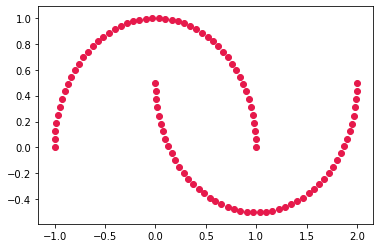

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
from utils import get_classification_data, show_data, visualise_predictions, colors
import matplotlib.pyplot as plt
import sklearn.datasets
from time import sleep

X, Y = sklearn.datasets.make_moons()
Y = np.zeros_like(Y)
# X, Y = get_classification_data()
show_data(X, Y)

distances: (100, 100)
[2 2 2 1 1 2 2 2 2 1 1 2 2 1 1 2 1 1 2 1 2 2 2 1 1 1 2 2 1 2 2 1 2 2 1 1 1
 2 2 2 2 2 1 1 1 2 2 2 1 1 1 2 1 2 2 1 2 2 1 1 1 1 2 2 1 2 2 2 2 2 2 2 1 1
 1 2 1 1 1 2 2 2 2 1 2 1 1 2 1 2 2 1 2 1 2 2 1 1 2 1]


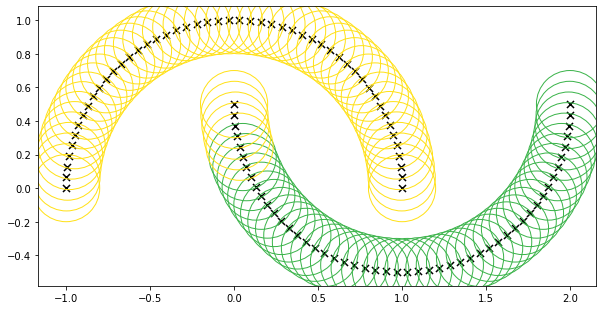

In [3]:

def compute_distances(input_X, dataset_X):
    """Takes in an array of inputs and finds each of their distances from every example in the dataset"""
    distances = np.zeros((len(input_X), len(dataset_X))) ## matrix of distances between each input x and each x in the dataset
    for i, this_x in enumerate(input_X): ## enumerate over the input
        for j, another_x in enumerate(dataset_X): ## enumerate over the dataset
            distance = np.linalg.norm(this_x - another_x) ## compute the euclidian distance
            distances[i][j] = distance
    return distances

class DBSCAN:
    def __init__(self, X, epsilon=5, min_pts=3):
        self.X = X
        self.epsilon = epsilon # the radius of the neighbourhood of each core point
        self.min_pts = min_pts + 1 # because we do not want it to consider itself as a neighbour
        # self.dataset_predictions = self.predict(self.X, self.X)
    
    # def classify_neighbours(self, x)

    def predict(self, X):
        # print(X)
        m = len(X)
        distances = compute_distances(X, self.X) ## compute the distances between
        within_radius = np.zeros_like(distances)
        within_radius[distances <= self.epsilon] = 1
        
        print('distances:', distances.shape)
        # print(within_radius)
        n_within_radius = np.sum(within_radius, axis=1) ## compute the number of neighbours for each datapoint
        # print(n_within_radius)
        core_pt_idxs = np.where(n_within_radius >= self.min_pts)[0] ## find the indices of the core points
        # print('core pts:', core_pt_idxs)
        non_core_pt_idxs = np.where(np.logical_and(n_within_radius > 1, n_within_radius < self.min_pts))[0] ## find the indices of the non-core points
        # print('non core pts:', non_core_pt_idxs)
        noise_pt_idxs = np.where(n_within_radius == 1)[0] ## find the indices of the noise points
        # print('noise pts:', noise_pt_idxs)
        
        predictions = np.zeros(m) ## initialise an empty list of predictions
        n_clusters_found = 1 ## initialise the cluster index (first cluster label) at 1 (noise points will keep the label, 0)

        indices_of_core_pts_classified = set() ## initialise an empty set of all of the points which we have classified thus far

        def get_neighbours_and_add_to_cluster(this_idx, cluster=set()):
            """Recursively find a datapoint's neighbour and add it to the cluster"""
            neighbour_idxs = get_neighbour_idxs(distances[this_idx]) ## get the indices of this datapoint's neighbours 
            for idx in neighbour_idxs: ## for each neighbour, 
                if idx in cluster: continue ## continue to the next neighbour if this one is already in the cluster
                cluster.add(idx) ## add this neighbour to the cluster
                child_cluster = get_neighbours_and_add_to_cluster(idx, cluster) ## find the neighbours of this neighbour and get a new cluster (recursion call)
                cluster = cluster.union(child_cluster) ## combine the current cluster and the one found from the line above
            return cluster ## return the cluster

        def get_neighbour_idxs(neighbour_distances):
            """Get the indices of the neighbours of a datapoint by checking if they are within the epsilon distance"""
            n = np.where(neighbour_distances <= self.epsilon)[0] ## get the indices of the points within the radius
            return n

        for idx in core_pt_idxs: ## for each core point (which we know will be part of a cluster)
            if idx in indices_of_core_pts_classified: ## if it has already been classified,
                # print('\talready classified')
                continue ## continue
            # print('cluster idx:', n_clusters_found)
            cluster = get_neighbours_and_add_to_cluster(idx) ## find the cluster of which this core pt is a member
            # print(cluster)
            indices_of_core_pts_classified = indices_of_core_pts_classified.union(cluster) ## add the indices of the points that are in this cluster to the list of indices of points that we have already classified
            cluster = list(cluster) ## convert cluster to a list
            # print(len(cluster))
            predictions[cluster] = n_clusters_found ## set the predictions of the datapoints in the cluster to the current cluster idx
            n_clusters_found += 1 ## increment the cluster index
        return predictions.astype(int) ## round the predictions and then return them

    def predict_vis(self, X):
        self.predict()

    def visualise(self, predictions):
        """Function to visualise the predictions made by DBSCAN"""
        plt.ion()
        plt.show()
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')

        for cluster_idx in list(set(predictions)):
            cluster_datapoints = self.X[predictions == cluster_idx]
            ax.scatter(cluster_datapoints[:, 0], cluster_datapoints[:, 1], s=50, marker='x', c='k')
            for x in cluster_datapoints:
                circle = plt.Circle((x[0], x[1]), self.epsilon, color=colors[cluster_idx], fill=False)
                ax.add_artist(circle)
        plt.show()

dbscan = DBSCAN(X, epsilon=0.2, min_pts=1)
cluster_predictions = dbscan.predict(X)
print(cluster_predictions)
dbscan.visualise(cluster_predictions)

## Limitations of DBSCAN
- We need to compute the distance between each point and each other point.
- The dataset may not contain samples that, in reality, are part of a cluster.

## Conclusion
At this point, you should have a good understanding of
- the DBSCAN algorithm.
- how to implement the DBSCAN algorithm from scratch.
- how to implement the DBSCAN algorithm in Sklearn.
